In [1]:
from plotting_functions import *
import matplotlib as mpl
import os
from scipy import stats
from matplotlib.colors import BoundaryNorm
from sklearn import metrics
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import Normalize

class PiecewiseNorm(Normalize):
    def __init__(self, levels, clip=False):
        # the input levels
        self._levels = np.sort(levels)
        # corresponding normalized values between 0 and 1
        self._normed = np.linspace(0, 1, len(levels))
        Normalize.__init__(self, None, None, clip)

    def __call__(self, value, clip=None):
        # linearly interpolate to get the normalized value
        return np.ma.masked_array(np.interp(value, self._levels, self._normed))


In [2]:
from matplotlib.font_manager import FontProperties

In [3]:
index = 705

-------

In [4]:
mask_h = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                         'wildfires_theo_keeping/live/ensemble_data/'+
                         'mask_conus_2000_2009.nc').mask.to_numpy()

mask_s = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                         'wildfires_theo_keeping/live/ensemble_data/'+
                         'mask_conus_2075_2084.nc').mask.to_numpy()
#ds_re = xr.open_dataset('/rds/general/user/tk22/ephemeral/ensemble_outputs/'+
#                         f'p_class_B_20000101_20091231_obs_{index}.nc')
ds_re = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                        'wildfires_theo_keeping/live/ensemble_summaries/'+
                        'p_class_B_19900101_20191231_obs_705.nc')

ds_re = ds_re.p.resample(time = '1Y').sum()
ds_re = ds_re * mask_h
ds_obs = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                         'wildfires_theo_keeping/live/ensemble_data/'+
                         'counts_B_FPAFOD_19920101_20201231.nc')
ds_obs = ds_obs.counts.resample(time = '1Y').sum()
ds_obs = ds_obs * mask_h

In [5]:
ds_hist = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                          'wildfires_theo_keeping/live/ensemble_summaries/'+
                          'annual_fires_705_historical.nc') * mask_h

ds_proj = xr.open_dataset('/rds/general/user/tk22/projects/leverhulme_'+
                          'wildfires_theo_keeping/live/ensemble_summaries/'+
                          'annual_fires_705_projected.nc') * mask_s

### Difference Between Models:

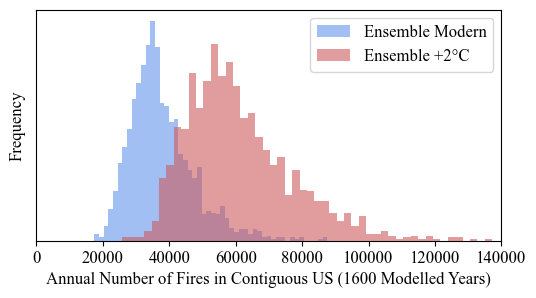

37794 ± 9806
60989 ± 16009
46764.21916212473
72439.10566535415


In [10]:
tnr = FontProperties(fname = '/rds/general/user/tk22/home/fonts/times.ttf', size = 12)

hist_yrs = (ds_hist.p * mask_h).sum(dim = ['latitude','longitude'])
proj_yrs = (ds_proj.p * mask_h).sum(dim = ['latitude','longitude'])

plt.figure(figsize = (6,3))
im = hist_yrs.plot.hist(bins = 50, color = 'cornflowerblue',
                        alpha = 0.6, label = 'Ensemble Modern')
im = proj_yrs.plot.hist(bins = 50, color = 'indianred',
                        alpha = 0.6, label = 'Ensemble +2°C')
plt.legend(prop = tnr)
plt.xlabel('Annual Number of Fires in Contiguous US (1600 Modelled Years)', font = tnr)
plt.yticks([])
plt.ylabel('Frequency', font = tnr)
plt.xlim((0,140000))
plt.xticks(font = tnr)
#plt.xlim((10000,140000))
#plt.xscale('log')
plt.savefig(('/rds/general/user/tk22/home/paper_2/'+
             f'final_figures/figures/supplementary_figure_3.jpg'), 
            bbox_inches = 'tight', facecolor = 'white', dpi = 300)
plt.show()

std_hist = float(hist_yrs.std())
std_proj = float(proj_yrs.std())
avg_hist = float(hist_yrs.mean())
avg_proj = float(proj_yrs.mean())
print(f'{avg_hist:.0f} ± {std_hist:.0f}')
print(f'{avg_proj:.0f} ± {std_proj:.0f}')
print(float(hist_yrs.quantile(0.99) - hist_yrs.quantile(0.01)))
print(float(proj_yrs.quantile(0.99) - proj_yrs.quantile(0.01)))

### Master Plot:

In [40]:
def full_summary_map(obs_mean, re_mean, mod_mean, fut_mean, mod_min, fut_min,
                     mod_max, fut_max, lower_bound = -1, upper_bound = 1,
                     color_map_1 = 'YlOrRd', color_map_2 = 'YlGnBu'):
    tnr = FontProperties(fname = '/rds/general/user/tk22/home/fonts/times.ttf', size = 12)
    tnr_big = FontProperties(fname = '/rds/general/user/tk22/home/fonts/times.ttf', size = 14)
    # Processing:
    bounds = list(np.logspace(lower_bound,upper_bound,int(np.floor((upper_bound-lower_bound)*3+1))))
    num_c = len(bounds)+2
    cmap = mpl.colormaps[color_map_1].resampled(num_c)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend = 'both')

    bounds_rel = list(np.logspace(0,0.778156,5))
    num_c_rel  = len(bounds_rel)+2
    cmap_rel   = mpl.colormaps[color_map_2].resampled(num_c_rel)
    norm_rel   = mpl.colors.BoundaryNorm(bounds_rel, cmap_rel.N, extend = 'both')

    # Figure:
    fig, axs = plt.subplots(3, 3, figsize = (12,6),
                            subplot_kw={'projection':
                                        ccrs.PlateCarree()})
    # Figure 1:
    axs[0,0].set_title('Observational Record', fontsize = 12, font = tnr_big)
    axs[0,0].set_global()
    axs[0,0].coastlines()
    axs[0,0].set_xlim(-125, -67)
    axs[0,0].set_ylim(24, 49.5)
    im1 = axs[0,0].pcolormesh(
        obs_mean.longitude, obs_mean.latitude, obs_mean,
        norm = norm, transform = ccrs.PlateCarree(), cmap = cmap)
    axs[0,0].coastlines()
    axs[0,0].text(-124, 25, f'(a) Observed Mean', color = 'k', font = tnr,
                  fontsize = 12, ha = 'left', va = 'bottom',
                  bbox = dict(facecolor = 'white',
                              edgecolor = 'white',
                              pad = 0))
    # Figure 2:
    axs[1,0].set_global()
    axs[1,0].coastlines()
    axs[1,0].set_xlim(-125, -67)
    axs[1,0].set_ylim(24, 49.5)
    im2 = axs[1,0].pcolormesh(
        re_mean.longitude, re_mean.latitude, re_mean,
        norm = norm, transform = ccrs.PlateCarree(), cmap = cmap)
    axs[1,0].coastlines()
    axs[1,0].text(-124, 25, f'(b) Reanalysis Mean', color = 'k', font = tnr,
                  fontsize = 12, ha = 'left', va = 'bottom',
                  bbox = dict(facecolor = 'white',
                              edgecolor = 'white',
                              pad = 0))
    # Figure 3:
    axs[2,0].axis('off') 
    # Figure 4:
    axs[0,1].set_title('Ensemble Modern', fontsize = 12, font = tnr_big)
    axs[0,1].set_global()
    axs[0,1].coastlines()
    axs[0,1].set_xlim(-125, -67)
    axs[0,1].set_ylim(24, 49.5)
    im4 = axs[0,1].pcolormesh(
        mod_mean.longitude, mod_mean.latitude, mod_mean,
        norm = norm, transform = ccrs.PlateCarree(), cmap = cmap)
    axs[0,1].coastlines()
    axs[0,1].text(-124, 25, f'(c) Mean', color = 'k', font = tnr,
                  fontsize = 12, ha = 'left', va = 'bottom',
                  bbox = dict(facecolor = 'white',
                              edgecolor = 'white',
                              pad = 0))
    # Figure 5:
    axs[1,1].set_global()
    axs[1,1].coastlines()
    axs[1,1].set_xlim(-125, -67)
    axs[1,1].set_ylim(24, 49.5)
    im5 = axs[1,1].pcolormesh(
        mod_mean.longitude, mod_mean.latitude, mod_max - mod_min,
        norm = norm, transform = ccrs.PlateCarree(), cmap = cmap)
    axs[1,1].coastlines()
    axs[1,1].text(-124, 25, f'(d) Spread', color = 'k', font = tnr,
                  fontsize = 12, ha = 'left', va = 'bottom',
                  bbox = dict(facecolor = 'white',
                              edgecolor = 'white',
                              pad = 0))
    # Figure 6:
    axs[2,1].set_global()
    axs[2,1].coastlines()
    axs[2,1].set_xlim(-125, -67)
    axs[2,1].set_ylim(24, 49.5)
    im6 = axs[2,1].pcolormesh(
        mod_mean.longitude, mod_mean.latitude, (mod_max - mod_min) / mod_mean,
        norm = norm_rel, transform = ccrs.PlateCarree(), cmap = cmap_rel)
    axs[2,1].coastlines()
    axs[2,1].text(-124, 25, f'(e) Spread / Mean', color = 'k', font = tnr,
                  fontsize = 12, ha = 'left', va = 'bottom',
                  bbox = dict(facecolor = 'white',
                              edgecolor = 'white',
                              pad = 0))
    # Figure 7:
    axs[0,2].set_title('Ensemble +2°C', fontsize = 12, font = tnr_big)
    axs[0,2].set_global()
    axs[0,2].coastlines()
    axs[0,2].set_xlim(-125, -67)
    axs[0,2].set_ylim(24, 49.5)
    im7 = axs[0,2].pcolormesh(
        fut_mean.longitude, fut_mean.latitude, fut_mean,
        norm = norm, transform = ccrs.PlateCarree(), cmap = cmap)
    axs[0,2].coastlines()
    axs[0,2].text(-124, 25, f'(f) Mean', color = 'k', font = tnr,
                  fontsize = 12, ha = 'left', va = 'bottom',
                  bbox = dict(facecolor = 'white',
                              edgecolor = 'white',
                              pad = 0))
    # Figure 8:
    axs[1,2].set_global()
    axs[1,2].coastlines()
    axs[1,2].set_xlim(-125, -67)
    axs[1,2].set_ylim(24, 49.5)
    im8 = axs[1,2].pcolormesh(
        fut_mean.longitude, fut_mean.latitude, fut_max - fut_min,
        norm = norm, transform = ccrs.PlateCarree(), cmap = cmap)
    axs[1,2].coastlines()
    axs[1,2].text(-124, 25, f'(g) Spread', color = 'k', font = tnr,
                  fontsize = 12, ha = 'left', va = 'bottom',
                  bbox = dict(facecolor = 'white',
                              edgecolor = 'white',
                              pad = 0))

    # Figure 9:
    axs[2,2].set_global()
    axs[2,2].coastlines()
    axs[2,2].set_xlim(-125, -67)
    axs[2,2].set_ylim(24, 49.5)
    im9 = axs[2,2].pcolormesh(
        fut_mean.longitude, fut_mean.latitude, (fut_max - fut_min)/fut_mean,
        norm = norm_rel, transform = ccrs.PlateCarree(), cmap = cmap_rel)
    axs[2,2].coastlines()
    axs[2,2].text(-124, 25, f'(h) Spread / Mean', color = 'k', font = tnr,
                  fontsize = 12, ha = 'left', va = 'bottom',
                  bbox = dict(facecolor = 'white',
                              edgecolor = 'white',
                              pad = 0))
    # Colorbars:
    plt.subplots_adjust(wspace = 0.04, hspace = 0.01)
    #fig.subplots_adjust(right = 0.95)

    #cbar_ax1 = fig.add_axes([0.965, 0.43, 0.012, 0.38])
    #cbar1 = fig.colorbar(im1, cax = cbar_ax1, extend = 'both', ticks = np.logspace(-3,3,7))
    #cbar1.set_label('Yearly Number of Fires', fontsize = 12, labelpad = 4)
    #fontsetter = [t.set_fontsize(12) for t in cbar_ax1.get_yticklabels()]
    
    #cbar_ax2 = fig.add_axes([0.965, 0.11, 0.012, 0.255])
    #cbar2 = fig.colorbar(im9, cax = cbar_ax2, extend = 'both', 
    #                     format = "%.1f")
    #cbar2.set_label('Spread Relative\nto Mean', fontsize = 12, labelpad = 4)
    #fontsetter = [t.set_fontsize(12) for t in cbar_ax2.get_yticklabels()]
    
    cbar_ax1 = fig.add_axes([0.125, 0.315, 0.25, 0.025])
    cbar1 = fig.colorbar(im1, cax = cbar_ax1, ticks = np.logspace(-3,3,7),
                         extend = 'both', orientation = 'horizontal')
    cbar1.set_label('Yearly Number of Fires', fontsize = 12, labelpad = 1, font = tnr)
    cbar1.set_ticks([0.1,1,10])
    cbar1.ax.set_xticklabels(['0.1','1','10'], font = tnr)
    #fontsetter = [t.set_fontsize(12) for t in cbar_ax1.get_yticklabels()]
    #fontsetter = [t.set_font(tnr) for t in cbar_ax1.get_yticklabels()]
    
    cbar_ax2 = fig.add_axes([0.125, 0.195, 0.25, 0.025])
    cbar2 = fig.colorbar(im9, cax = cbar_ax2, extend = 'both',
                         orientation = 'horizontal', format = "%.1f")
    cbar2.set_label('Spread Relative to Mean', fontsize = 12, labelpad = 1, font = tnr)
    cbar2.set_ticks(bounds_rel)
    cbar2.ax.set_xticklabels(['1','1.6','2.4','3.8','6.0'], font = tnr)
    
    
    #fontsetter = [t.set_fontsize(12) for t in cbar_ax2.get_yticklabels()]
    #fontsetter = [t.set_font(tnr) for t in cbar_ax2.get_yticklabels()]
    

    plt.savefig(('/rds/general/user/tk22/home/paper_2/'+
                 f'final_figures/figures/figure_1.jpg'), 
                bbox_inches = 'tight', facecolor = 'white', dpi = 600)
    plt.show()
    return

In [12]:
#obs_mean = ds_obs.sel(time = np.logical_and(
#    ds_obs.time.dt.year >= 2000, 
#    ds_obs.time.dt.year <= 2009)).mean(dim = 'time').clip(min = 10**-10)

obs_mean = ds_obs.mean(dim = 'time').clip(min = 10**-10)


re_mean  = ds_re.mean(dim = 'time')

mod_mean = ds_hist['p'].mean(dim = ['member','time'])
fut_mean = ds_proj['p'].mean(dim = ['member','time'])

mod_min  = ds_hist['p'].quantile(0.01, dim = ['member','time'])
fut_min  = ds_proj['p'].quantile(0.01, dim = ['member','time'])

mod_max  = ds_hist['p'].quantile(0.99, dim = ['member','time'])
fut_max  = ds_proj['p'].quantile(0.99, dim = ['member','time'])

/rds/general/user/tk22/home/miniconda3/envs/firepy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [7]:
x1 = mod_mean.to_numpy().flatten()
x2 = re_mean.to_numpy().flatten()
nan_mask = np.logical_or(np.isnan(x1),np.isnan(x2))
print(f'R2: {metrics.r2_score(x1[~nan_mask], x2[~nan_mask]):.2f}')

x1 = mod_mean.to_numpy().flatten()
x2 = (mod_max - mod_min).to_numpy().flatten()
nan_mask = np.logical_or(np.isnan(x1),np.isnan(x2))
print(f'R2: {metrics.r2_score(x1[~nan_mask], x2[~nan_mask]):.2f}')

x1 = mod_mean.to_numpy().flatten()
x2 = fut_mean.to_numpy().flatten()
nan_mask = np.logical_or(np.isnan(x1),np.isnan(x2))
print(f'R2: {metrics.r2_score(x1[~nan_mask], x2[~nan_mask]):.2f}')

x1 = (mod_max - mod_min).to_numpy().flatten()
x2 = (fut_max - fut_min).to_numpy().flatten()
nan_mask = np.logical_or(np.isnan(x1),np.isnan(x2))
print(f'R2: {metrics.r2_score(x1[~nan_mask], x2[~nan_mask]):.2f}')

R2: 0.96
R2: -0.76
R2: 0.62
R2: 0.45


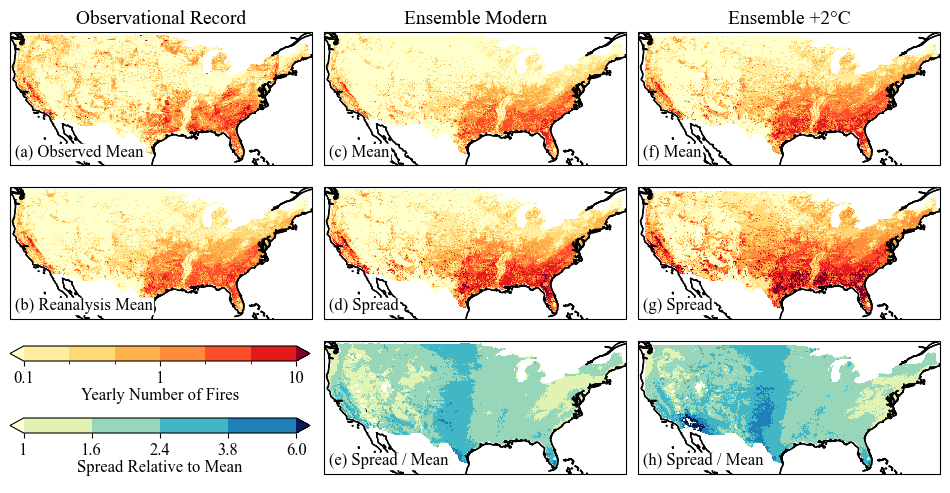

In [41]:
full_summary_map(obs_mean, re_mean, mod_mean, fut_mean, mod_min, fut_min,
                 mod_max, fut_max, lower_bound = -1, upper_bound = 1,
                 color_map_1 = 'YlOrRd', color_map_2 = 'YlGnBu')

In [31]:
def above_below(spread_to_mean, fraction = 1):
    above = np.nansum((spread_to_mean > fraction))
    below = np.nansum((spread_to_mean <= fraction))
    return 100 * above / (above + below)

In [27]:
def delta_quantile(spread_to_mean, mean_ratio, q = 0.9):
    ratio_quantile = spread_to_mean[mean_ratio > np.quantile(mean_ratio, q)]
    ratio_quantile = ratio_quantile[~np.isinf(ratio_quantile)]
    return np.nanmean(ratio_quantile)

In [13]:
mean_ratio = mask_s * (fut_mean / mod_mean)
spread_ratio = mask_s * ((fut_max - fut_min) / (mod_max - mod_min))
spread_to_mean = (spread_ratio / mean_ratio)

In [22]:
new_mask = ~np.isnan(spread_to_mean.to_numpy().flatten())
mean_ratio = mean_ratio.to_numpy().flatten()[new_mask]
spread_ratio = spread_ratio.to_numpy().flatten()[new_mask]
spread_to_mean = spread_to_mean.to_numpy().flatten()[new_mask]

In [28]:
print(0.0, delta_quantile(spread_to_mean, mean_ratio, q = 0.0))
print(0.2, delta_quantile(spread_to_mean, mean_ratio, q = 0.2))
print(0.4, delta_quantile(spread_to_mean, mean_ratio, q = 0.4))
print(0.6, delta_quantile(spread_to_mean, mean_ratio, q = 0.6))
print(0.8, delta_quantile(spread_to_mean, mean_ratio, q = 0.8))
print(1.0, delta_quantile(spread_to_mean, mean_ratio, q = 0.9))

0.0 1.1772025759360059
0.2 1.1676225658579784
0.4 1.141700637635751
0.6 1.143533924082689
0.8 1.1496115539313758
1.0 1.1790668159566886


In [34]:
print(f'{above_below(spread_to_mean, fraction = 0.8):.3f}%')
print(f'{above_below(spread_to_mean, fraction = 0.9):.3f}%')
print(f'{above_below(spread_to_mean, fraction = 1.0):.3f}%')
print(f'{above_below(spread_to_mean, fraction = 1.1):.3f}%')
print(f'{above_below(spread_to_mean, fraction = 1.2):.3f}%')
print(f'{above_below(spread_to_mean, fraction = 1.3):.3f}%')
print(f'{above_below(spread_to_mean, fraction = 1.4):.3f}%')
print(f'{above_below(spread_to_mean, fraction = 1.5):.3f}%')

99.411%
93.971%
77.643%
54.680%
34.057%
20.234%
10.963%
5.281%


### Mean Ratio:

In [42]:
mean_hist = ds_hist.p.mean(dim = ['member','time'])
mean_proj = ds_proj.p.mean(dim = ['member','time'])
max_hist = ds_hist.p.quantile(0.99,dim = ['member','time'])
max_proj = ds_proj.p.quantile(0.99,dim = ['member','time'])
min_hist = ds_hist.p.quantile(0.01,dim = ['member','time'])
min_proj = ds_proj.p.quantile(0.01,dim = ['member','time'])
spread_hist = max_hist - min_hist
spread_proj = max_proj - min_proj

/rds/general/user/tk22/home/miniconda3/envs/firepy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


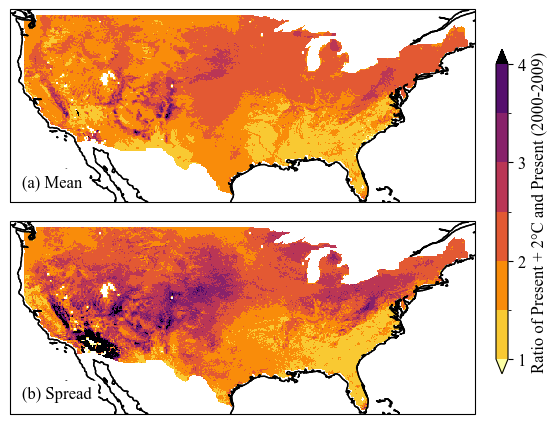

In [46]:
tnr = FontProperties(fname = '/rds/general/user/tk22/home/fonts/times.ttf',
                     size = 12)

fig = plt.figure(figsize = (6,5.5))

ax = fig.add_subplot(211, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.set_xlim(-125.5, -66.5)
ax.set_ylim(25, 49.5)
bounds = list(np.linspace(1,4,7))
num_c = len(bounds)+2
cmap = mpl.colormaps['inferno_r'].resampled(num_c)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend = 'both')
im = ax.pcolormesh(
    mean_hist.longitude, mean_hist.latitude, mean_proj / mean_hist,
    norm = norm,
    transform = ccrs.PlateCarree(),
    cmap = cmap)
ax.coastlines()
ax.text(-124, 27, '(a) Mean', color = 'k', font = tnr, 
         bbox=dict(facecolor = 'white', edgecolor = 'white'))


ax = fig.add_subplot(212, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.set_xlim(-125.5, -66.5)
ax.set_ylim(25, 49.5)
bounds = list(np.linspace(1,4,7))
num_c = len(bounds)+2
cmap = mpl.colormaps['inferno_r'].resampled(num_c)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend = 'both')
im = ax.pcolormesh(
    spread_hist.longitude, spread_hist.latitude, spread_proj / spread_hist,
    norm = norm,
    transform = ccrs.PlateCarree(),
    cmap = cmap)
ax.coastlines()
ax.text(-124, 27, '(b) Spread', color = 'k', font = tnr, 
         bbox=dict(facecolor = 'white', edgecolor = 'white'))

plt.subplots_adjust(wspace=0, hspace=0)


fig.subplots_adjust(right = 0.9)
cbar_ax = fig.add_axes([0.935, 0.2, 0.02, 0.59])
cbar = fig.colorbar(im, cax = cbar_ax, extend = 'both', ticks = [1,2,3,4])
cbar.set_label('Ratio of Present + 2°C and Present (2000-2009)', font = tnr)
cbar.ax.set_yticklabels(['1','2','3','4'],font = tnr)

plt.savefig(('/rds/general/user/tk22/home/paper_2/'+
             f'final_figures/figures/supplementary_figure_5.jpg'), 
            bbox_inches = 'tight', facecolor = 'white', dpi = 300)
plt.show()
